In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import cluster, mixture
from sklearn.metrics import (calinski_harabasz_score,
                             davies_bouldin_score,
                             silhouette_score,
                             adjusted_rand_score,
                             fowlkes_mallows_score)

import hdbscan

In [3]:
data = pd.read_csv("./data_transformed.csv", index_col=0)

In [4]:
data

,n_words,n_unique_words,long_word_freq,mean_word_length,single_use_word_freq,eth_freq,PROPN_freq,NOUN_freq,ADJ_freq,VERB_freq,...,anticipation_freq,disgust_freq,fear_freq,joy_freq,negative_freq,positive_freq,sadness_freq,surprise_freq,trust_freq,named_entities_freq
Book,,,,,,,,,,,,,,,,,,,,,
Buddhism,1.805769,0.256573,0.639198,0.637853,-2.778243,-0.375587,-0.094018,-0.961272,0.648272,0.613734,...,-0.596172,1.504661,0.407991,0.319668,-0.001656,-0.586864,0.929658,-0.515602,0.027511,-0.315839
Buddhism,0.036538,-0.383772,0.963936,0.619943,-2.742443,-0.375587,-1.004111,1.151430,0.361970,-0.296266,...,-1.034234,-0.046232,-1.095521,-0.305302,1.849496,0.213243,-1.076177,-0.450737,1.207296,-0.670465
Buddhism,0.804141,0.160521,-0.236586,0.123760,-1.878744,-0.375587,-1.361454,1.397753,-0.240857,0.252338,...,-0.360891,-0.341185,0.161841,-1.162987,3.590734,-0.921661,0.601269,-0.176494,-0.778542,-0.508630
Buddhism,0.251841,-0.335746,-0.076691,0.733189,-2.660575,-0.375587,-0.475757,1.330137,-1.179656,-0.173409,...,-0.554543,-0.959375,-0.733375,-0.994072,0.662142,0.572586,-0.721875,-0.628964,1.864328,-0.327573
Buddhism,-0.815314,-1.008109,10.368032,3.805384,-2.018067,-0.375587,-0.254947,3.955570,-2.066562,-2.978327,...,-1.292159,-0.959375,1.774820,0.592091,1.053190,-0.998082,1.029950,-0.791279,1.049490,0.749361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bible,1.253469,1.649324,-0.586189,-0.780794,-0.420176,2.825311,1.091009,0.228580,-0.006197,-0.897560,...,0.255389,-0.046232,0.086384,0.816439,0.039711,-0.490107,0.162721,-0.223708,0.260462,0.146682
Bible,2.564010,2.577825,-0.411388,-0.580280,-1.148732,0.754518,1.083421,-0.455049,-1.001567,0.492919,...,-0.405362,0.610410,0.839540,-0.157837,0.624536,-0.677140,0.059711,-0.335947,-0.231572,-0.244716
Bible,1.347079,2.017523,-0.185425,-0.032473,0.222265,0.200185,-0.981271,-0.418665,0.200726,1.014039,...,-0.396850,0.259743,1.068505,-0.865585,1.317362,-1.224144,1.404862,-0.154768,-0.937952,-0.501121


In [5]:
def create_clustering_algorithms(n_clusters):

    minibatch = cluster.MiniBatchKMeans(n_clusters=n_clusters)
    agglomerative_average = cluster.AgglomerativeClustering(
        n_clusters=n_clusters, linkage="average")
    birch = cluster.Birch(n_clusters=n_clusters)
    gmm = mixture.GaussianMixture(n_components=n_clusters)

    # Automatically selects number of clusters
    dbscan = cluster.DBSCAN()
    optics = cluster.OPTICS()
    affinity_propagation = cluster.AffinityPropagation()
    mean_shift = cluster.MeanShift()
    hdb = hdbscan.HDBSCAN()

    clustering_algorithms = (('MiniBatchKMeans', minibatch),
                             ('Agglomerative_Average', agglomerative_average),
                             ('Birch', birch), ('GaussianMixture', gmm),
                             ('DBSCAN', dbscan),
                             ('optics', optics),
                             ('Affinity_Propagation', affinity_propagation),
                             ('Mean_Shift', mean_shift),
                             ('HDBSCAN', hdb))

    return clustering_algorithms

In [6]:
algorithms_names = ['MiniBatchKMeans', 'Agglomerative_Average', 'Birch', 'GaussianMixture',
                    'DBSCAN', 'optics', 'Affinity_Propragation', 'Mean_Shift', 'HDBSCAN']

In [7]:
def calculate_cluster_metrics(n_cluster_min, n_cluster_max, dataset):

    silhouette_scores = pd.DataFrame(
        index=range(2, 15), columns=algorithms_names)
    davies_bouldin_scores = pd.DataFrame(
        index=range(2, 15), columns=algorithms_names)
    calinski_harabasz_scores = pd.DataFrame(
        index=range(2, 15), columns=algorithms_names)
    adjusted_rand_scores = pd.DataFrame(
        index=range(2, 15), columns=algorithms_names)
    fowlkes_mallows_scores = pd.DataFrame(
        index=range(2, 15), columns=algorithms_names)

    for n_clusters in range(n_cluster_min, n_cluster_max):

        clustering_algorithms = create_clustering_algorithms(n_clusters)

        for name, algorithm in clustering_algorithms:

            algorithm.fit(dataset)

            if hasattr(algorithm, 'labels_'):
                y_pred = algorithm.labels_.astype(np.int)
            else:
                y_pred = algorithm.predict(dataset)

            try:
                db_score = davies_bouldin_score(dataset, y_pred)
            except:
                db_score = 1
            try:
                ch_score = calinski_harabasz_score(dataset, y_pred)
            except:
                ch_score = 0
            try:
                s_score = silhouette_score(dataset, y_pred)
            except:
                s_score = 0

            ad_score = adjusted_rand_score(data.index, y_pred)
            fm_score = fowlkes_mallows_score(data.index, y_pred)

            davies_bouldin_scores.loc[n_clusters, name] = db_score
            calinski_harabasz_scores.loc[n_clusters, name] = ch_score
            silhouette_scores.loc[n_clusters, name] = s_score

            adjusted_rand_scores.loc[n_clusters, name] = ad_score
            fowlkes_mallows_scores.loc[n_clusters, name] = fm_score

    return silhouette_scores, davies_bouldin_scores, calinski_harabasz_scores, adjusted_rand_scores, fowlkes_mallows_scores

In [8]:
silhouette_scores, davies_bouldin_scores, calinski_harabasz_scores, adjusted_rand_scores, fowlkes_mallows_scores = calculate_cluster_metrics(
    2, 15, data)

In [9]:
def plot_cluster_metrics(silhouette_scores, davies_bouldin_scores, calinski_harabasz_scores):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    davies_bouldin_scores.plot(
        ax=axes[0], legend=None, title='davies_bouldain')

    calinski_harabasz_scores.plot(
        ax=axes[1], legend=None, title='calinski_harabasz')

    silhouette_scores.plot(ax=axes[2], title='silhouette')

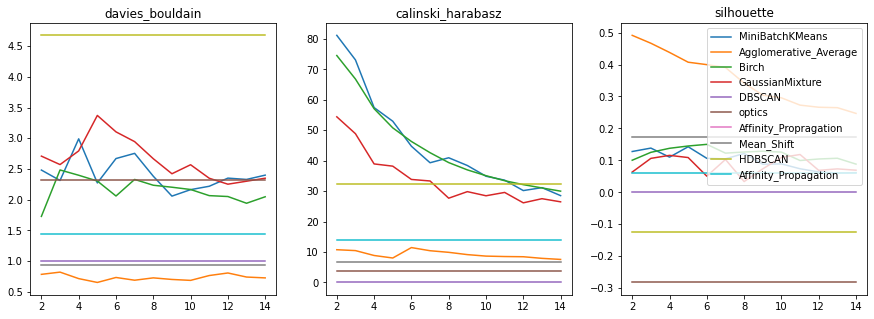

In [10]:
plot_cluster_metrics(
    silhouette_scores, davies_bouldin_scores, calinski_harabasz_scores)

In [11]:
def plot_cluster_metrics_2(adjusted_rand_scores, fowlkes_mallows_scores):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

    adjusted_rand_scores.plot(ax=axes[0], legend=None, title='adjusted_rand')

    fowlkes_mallows_scores.plot(ax=axes[1], title='fowlkes_mallows')

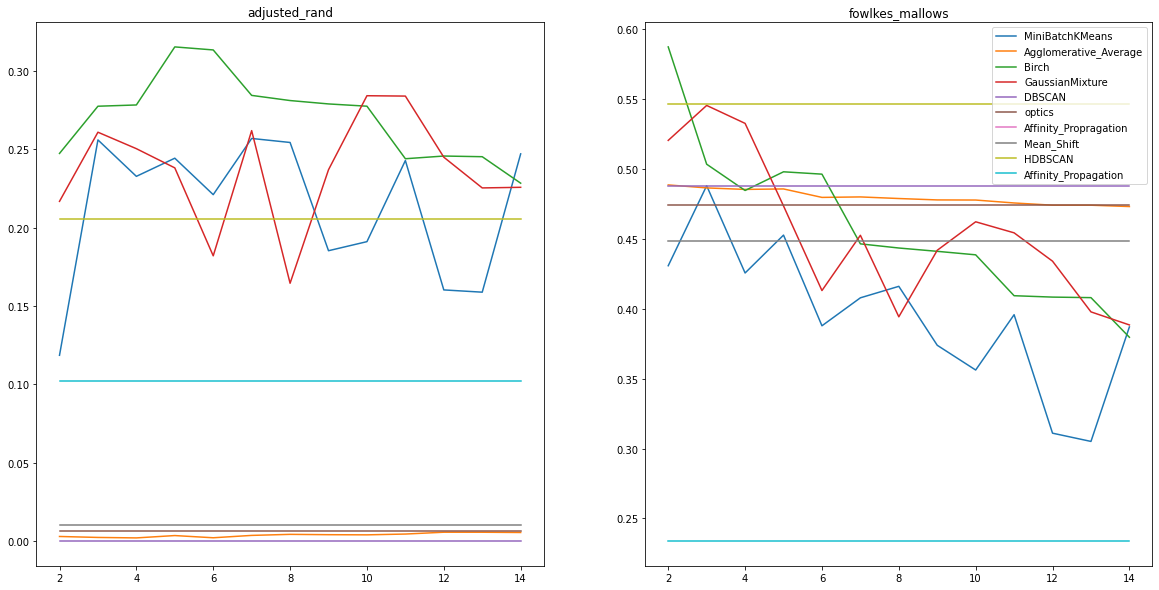

In [12]:
plot_cluster_metrics_2(adjusted_rand_scores, fowlkes_mallows_scores)

In [13]:
for name, algorithm in create_clustering_algorithms(5)[-5:]:

    y_pred = algorithm.fit_predict(data)
    print(f"{name} created {len(np.unique(y_pred))} clusters")

DBSCAN created 1 clusters
optics created 5 clusters
Affinity_Propagation created 61 clusters
Mean_Shift created 28 clusters
HDBSCAN created 3 clusters


Conclusions:
- dataset was really hard to properly cluster
- metrics based on similarity within clusters can't find optimal number of clusters and based on them one might choose **agglomerative clustering or birch/mini batch k-means**
- metrics based on knowledge of the ground truth class assignments show that algorithms with option of selecting number of clusters are generally better than those that find optimal number of clusters automatically (with exception of HDBSCAN) and based on them one might choose **Birch or Gaussian Measure**
- algorithms that find optimal number of clusters automatically have many hyperparameters and tuning them may give better results